<a href="https://colab.research.google.com/github/henilp105/FMML2022-henilp105/blob/main/credit_underwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, accuracy_score
import tensorflow as tf
from tensorflow import keras

In [ ]:
!wget https://henilp105.vercel.app/static/financial.xlsx #https://ruslanmv.com/blog/The-best-binary-Machine-Learning-Model

In [ ]:
missing_value_formats = ["n.a.","?","NA","n/a", "na", "--"]
df = pd.read_excel('financial.xlsx', na_values = missing_value_formats)    # upload the file with name 'financial.xlsx'
df.head()

,ACCT_NUMBER,BALANCE,SANCTIONAMOUNT,COLLATERALTYPE,COLLATERALVALUE,CREDITLIMIT,DATECLOSED,DATEOPENED,HIGHCREDIT,INSTALLMENTAMOUNT,PASTDUEAMOUNT,REPAYMENTTENURE,TERMFREQUENCY,SELF_TRADE,SECTOR,DOB,Defaulter
0,1024,0.0,50000,NaN,0.0,0.0,2021-09-04,2019-11-29,50000.0,1195.0,0.0,52.0,Bi-weekly,N,NBFC,1971-01-01,0
1,1025,71704.0,80000,NaN,0.0,0.0,NaT,2021-09-04,80000.0,4146.0,0.0,24.0,Monthly,N,NBFC,1971-01-01,0
2,1026,0.0,15000,NaN,NaN,NaN,2014-12-16,2014-01-03,NaN,358.0,0.0,NaN,Monthly,NaN,NaN,1988-05-10,0
3,1027,0.0,20000,NaN,NaN,NaN,2018-02-15,2017-03-15,NaN,907.0,NaN,NaN,Bi-weekly,NaN,NaN,1988-05-10,0
4,1028,21795.0,21795,NaN,NaN,NaN,NaT,2021-08-15,NaN,NaN,0.0,NaN,Monthly,NaN,NaN,1978-01-01,0


In [ ]:
df = df.fillna({
    'BALANCE': 0,
    'COLLATERALVALUE': 0, 
    'COLLATERALTYPE': 0, 
    'CREDITLIMIT': 0, 
    'INSTALLMENTAMOUNT': 0, 
    'PASTDUEAMOUNT': 0, 
    'REPAYMENTTENURE': 0, 
    'SELF_TRADE': 'Y', 
    'DATECLOSED': '1999-12-31', 
    'DATEOPENED': '1999-12-31', 
    'SECTOR': 'NA', 
    'HIGHCREDIT': 0, 
    'TERMFREQUENCY': "NA"
})
df.head()

In [ ]:
df['DATEOPENED'] = pd.to_datetime(df['DATEOPENED'].astype(str)).dt.normalize()
df['DATECLOSED'] = pd.to_datetime(df['DATECLOSED'].astype(str)).dt.normalize()
df['DOB'] = pd.to_datetime(df['DOB'].astype(str)).dt.normalize()

df['age_l'] = (df['DATEOPENED'] - df['DOB']).dt.days / 365
df['age_le'] = (df['DATECLOSED'] - df['DOB']).dt.days / 365

df.loc[df['age_l'] < 20, 'age_l'] = 0
df.loc[((df['age_l'] > 20) & (df['age_l']<50)), 'age_l'] = 1
df.loc[((df['age_l'] > 50) & (df['age_l']<80)), 'age_l'] = 2
df.loc[df['age_l'] > 80, 'age_l'] = 3
df.loc[df['age_le'] < 20, 'age_le'] = 0
df.loc[((df['age_le'] > 20) & (df['age_le']<50)), 'age_le'] = 1
df.loc[((df['age_le'] > 50) & (df['age_le']<80)), 'age_le'] = 2
df.loc[df['age_le'] > 80, 'age_le'] = 3
corr = df.corr()
corr.style.background_gradient(cmap ='crest')

,ACCT_NUMBER,BALANCE,SANCTIONAMOUNT,COLLATERALTYPE,COLLATERALVALUE,CREDITLIMIT,HIGHCREDIT,INSTALLMENTAMOUNT,PASTDUEAMOUNT,REPAYMENTTENURE,Defaulter,age_l,age_le
ACCT_NUMBER,1.000000,-0.083359,-0.042529,-0.069222,-0.019294,-0.023630,-0.044977,-0.021949,-0.033477,-0.110481,0.618267,0.029231,0.056170
BALANCE,-0.083359,1.000000,0.071622,0.150989,0.150309,0.095755,0.072803,0.079014,0.309001,0.452549,-0.118181,0.033967,-0.118601
SANCTIONAMOUNT,-0.042529,0.071622,1.000000,-0.000599,0.016503,0.005655,0.999950,0.010874,0.021065,0.068565,-0.028416,-0.003274,-0.037355
COLLATERALTYPE,-0.069222,0.150989,-0.000599,1.000000,0.155913,-0.000044,0.001099,0.024464,0.047613,0.213637,-0.086514,-0.018603,-0.021789
COLLATERALVALUE,-0.019294,0.150309,0.016503,0.155913,1.000000,0.007240,0.016915,0.022779,0.186811,0.155366,-0.027136,-0.007182,0.003789
CREDITLIMIT,-0.023630,0.095755,0.005655,-0.000044,0.007240,1.000000,0.006004,0.005815,-0.002501,0.105037,-0.023646,-0.003217,-0.002605
HIGHCREDIT,-0.044977,0.072803,0.999950,0.001099,0.016915,0.006004,1.000000,0.011005,0.021702,0.070819,-0.031518,-0.003689,-0.037193
INSTALLMENTAMOUNT,-0.021949,0.079014,0.010874,0.024464,0.022779,0.005815,0.011005,1.000000,0.020814,0.053185,-0.018554,0.032511,0.025564
PASTDUEAMOUNT,-0.033477,0.309001,0.021065,0.047613,0.186811,-0.002501,0.021702,0.020814,1.000000,0.077716,-0.023594,0.001895,-0.032649
REPAYMENTTENURE,-0.110481,0.452549,0.068565,0.213637,0.155366,0.105037,0.070819,0.053185,0.077716,1.000000,-0.145337,0.003708,-0.041578


In [ ]:
print(df.isnull().sum())
df.loc[df.Defaulter ==1]

In [ ]:
models = {}

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

params = 'BALANCE	SANCTIONAMOUNT	COLLATERALTYPE	COLLATERALVALUE	CREDITLIMIT	HIGHCREDIT INSTALLMENTAMOUNT	PASTDUEAMOUNT	REPAYMENTTENURE	age_l	age_le'
params = params.split()
X = df[params]
y = df['Defaulter']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(X_train, y_train)
    
    # Prediction 
    predictions = models[key].predict(X_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

In [ ]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Decision Trees,0.946300,0.794979,0.837004
Random Forest,0.955667,0.794979,0.896226
Naive Bayes,0.288792,0.981172,0.171293
K-Nearest Neighbor,0.954106,0.780335,0.898795


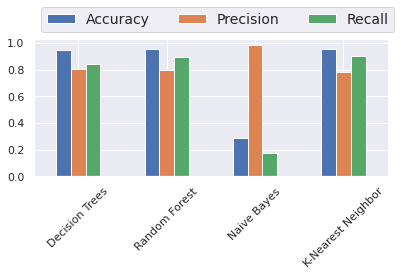

In [ ]:
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.tight_layout()